
# Description
**Influencias en el rendimiento académico**
* eng: **Influences on academic performance**

A study has been carried out to see if the academic performance of children is influenced by the academic level of their parents. Therefore, the academic results of the students will be evaluated based on several variables.


## *Dataset*
A dataset of 800 rows for the training [(train)](https://challenges-asset-files.s3.us-east-2.amazonaws.com/Events/Talent+Squad+League/3rd_batch/data/train.csv) of the prediction algorithm and 200 for the testing [(test)](https://challenges-asset-files.s3.us-east-2.amazonaws.com/Events/Talent+Squad+League/3rd_batch/data/test.csv).

## *Variables:*
- `gender` : student`s gender

- `parental level of education`: educational level of the parents

- `lunch`: school lunch

- `test preparation course`: attend the prep course

- `math score`: Math score

- `reading score`: Reading score

- `writing score`: Writing score

## *Goal*
The goal of the challenge is to predict if the student's academic results are influenced by the educational level of the parents. These have a number that represents the following educational level:

- high school: 0,

- some high school: 1,

- some college: 2,

- associate's degree: 3,

- bachelor's degree: 4,

- master's degree: 5

## *Evaluation*
The evaluation will be based on the objectives met, the quality of the code, and the documentation.

<img src="https://i.postimg.cc/XYgjnhD3/image-8.png" alt="evaluation" title="Evaluation" height="250"/>

## *Delivery Requirements*

1. Check that the main delivery branch is **main**.

2. The code should be delivered in a **py file called app.py**. In this, you will have all the functions used and the necessary code together with documentation to reproduce your solution. 
3. For the graphics we recommend you **deliver it in an ipynb**.

4. For documentation to count, it must have a **README.md** with the following structure and the following titles:

- background
- problem
- results
- analysis
- solution
- license

5. To SCORE the PREDICTIONS the delivered repository has to have a file:

- **predictions.json** with [this format](https://github.com/nuwe-io/data-analyser-test-repo/blob/main/predictions.json)

# Import

In [1]:
# installing lazypredict in order to build lot's of basic models
# and understand which models works better without any parameter tuning 
#pip install lazypredict

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics, preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn import *

le = preprocessing.LabelEncoder()

RNDM = 1234
warnings.simplefilter(action='ignore', category=FutureWarning)

# EDA

In [3]:
# test dataset
try:
    df_train = pd.read_csv('https://challenges-asset-files.s3.us-east-2.amazonaws.com/Events/Talent+Squad+League/3rd_batch/data/train.csv', sep=',')
except:
    df_train = pd.read_csv('/train.csv', sep=',')
df_train.head()

,Unnamed: 0,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,764,female,1,standard,none,62,76,67
1,866,male,4,standard,none,79,57,58
2,208,female,2,standard,none,77,86,84
3,337,female,0,free/reduced,none,45,46,49
4,323,male,3,standard,completed,82,83,85


In [4]:
# Test dataset
try:
    df_test = pd.read_csv('https://challenges-asset-files.s3.us-east-2.amazonaws.com/Events/Talent+Squad+League/3rd_batch/data/test.csv', sep=',')
except:
    df_test = pd.read_csv('test.csv', sep=',')
df_test.head()

,Unnamed: 0,gender,lunch,test preparation course,math score,reading score,writing score
0,79,male,standard,none,54,43,45
1,277,female,standard,none,72,77,77
2,855,female,standard,none,87,97,100
3,922,male,standard,none,55,55,55
4,332,male,standard,none,56,54,43


In [5]:
train = df_train.copy()
test = df_test.copy()

In [6]:
# Function for checking NaN, Shape and Target-values in train and test
def na0(df):
    return [df.isin([0]).sum().sum(),df.isin([1]).sum().sum(),df.isin([2]).sum().sum(), df.isna().sum().sum(), df.shape]

displ=[]
for df in train, test:
    displ.append(na0(df)) 
pd.DataFrame(displ, columns=['zeros','ones','twos', 'NaN', 'shape'])

,zeros,ones,twos,NaN,shape
0,166,150,188,0,"(800, 8)"
1,0,0,0,0,"(200, 7)"


In [7]:
# Let's define a function for studying the dataset, we will apply it to different dataframes
def evaluate_df(df, show_corr_zero_plots = False, show_corr_null_plots=False, show_scatter_matrix=False):
    print('\n------SAMPLE--------')
    display(df.sample(min(5,len(df))))
    print('\n------DTYPES--------')
    print(df.dtypes)

    # number of NaN & zero
    print('\n\n------NaN & zero--------')
    na = pd.DataFrame(index=df.columns
                      , data={
                          'NA':df.isna().sum().values
                          , 'filled': df.notna().sum().values
                          , 'zero':df.isin([0,'0']).sum()
                          , 'duplicates':df.duplicated().sum()
                      }
                     )
    na['%na'] = na['NA']/len(df)*100
    print(na.replace(0,'-'))

    # Statistics
    display(df.describe(include='all').transpose())

    # Unique Values
    for i in df.columns[1:]:
        print(df[i].unique())

    # Distribution
    
    for feature in df.columns[:]:
        _ = sns.histplot(data=df, x=feature, binwidth=0.3)
        plt.show()

In [8]:
train = df_train.copy()
train.drop(["Unnamed: 0"], axis=1, inplace=True)
test = df_test.copy()
test.drop(["Unnamed: 0"], axis=1, inplace=True)

Let's rename columns

In [9]:
train.columns

Index(['gender', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

In [10]:
train = train.rename(columns={'parental level of education':'parental_ed', 
                    'test preparation course':'test_prep', 'math score':'math_score', 
                    'reading score':'reading_score','writing score':'writing_score'})
train.columns = train.columns.str.lower()
train.columns

Index(['gender', 'parental_ed', 'lunch', 'test_prep', 'math_score',
       'reading_score', 'writing_score'],
      dtype='object')

In [11]:
test = test.rename(columns={'parental level of education':'parental_ed', 
                    'test preparation course':'test_prep', 'math score':'math_score', 
                    'reading score':'reading_score','writing score':'writing_score'})
test.columns = test.columns.str.lower()
test.columns

Index(['gender', 'lunch', 'test_prep', 'math_score', 'reading_score',
       'writing_score'],
      dtype='object')

Adding `total_score` to datasets

In [12]:
train['total_score']=(train['math_score']+train['reading_score']+train['writing_score'])/3
test['total_score']=(test['math_score']+test['reading_score']+test['writing_score'])/3

## Evaluation of Datasets

Train-dataset eveluation


------SAMPLE--------


,gender,parental_ed,lunch,test_prep,math_score,reading_score,writing_score,total_score
321,female,4,standard,none,84,87,92,87.67
220,male,0,standard,completed,53,59,64,58.67
155,male,3,free/reduced,none,56,50,43,49.67
262,female,1,free/reduced,none,39,50,49,46.00
94,female,0,free/reduced,none,58,72,70,66.67



------DTYPES--------
gender            object
parental_ed        int64
lunch             object
test_prep         object
math_score         int64
reading_score      int64
writing_score      int64
total_score      float64
dtype: object


------NaN & zero--------
              NA  filled zero  duplicates %na
gender         -     800    -           2   -
parental_ed    -     800  165           2   -
lunch          -     800    -           2   -
test_prep      -     800    -           2   -
math_score     -     800    -           2   -
reading_score  -     800    -           2   -
writing_score  -     800    -           2   -
total_score    -     800    -           2   -


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,800,2,male,417,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parental_ed,800.00,NaN,NaN,NaN,2.04,1.52,0.00,1.00,2.00,3.00,5.00
lunch,800,2,standard,509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_prep,800,2,none,525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
math_score,800.00,NaN,NaN,NaN,66.57,15.71,13.00,56.00,67.00,78.00,100.00
reading_score,800.00,NaN,NaN,NaN,69.14,14.82,27.00,60.00,70.00,79.00,100.00
writing_score,800.00,NaN,NaN,NaN,67.83,15.74,23.00,58.00,68.00,79.00,100.00
total_score,800.00,NaN,NaN,NaN,67.85,14.68,21.67,58.67,68.00,78.67,100.00


[1 4 2 0 3 5]
['standard' 'free/reduced']
['none' 'completed']
[ 62  79  77  45  82  32  53  57  67  74  63  49  89  66  78  72  76  97
 100  75  65  60  83  43  88  71  80  54  48  70  84  55  59  61  69  92
  56  68  81  85  41  87  47  58  28  39  95  38  51  40  98  73  94  29
  36  64  23  52  90  37  86  50  30  46  91  93  96  42  99  33  44  35
  26  25  34  31  13]
[ 76  57  86  46  83  41  70  47  65  71  73  37  84  64  78  66  80  88
  36 100  50  61  95  68  85  87  77  82  62  72  79  43  54  90  48  97
  93  58  60  55  59  53  74  52  81  75  49  44  32  56  63  42  94  92
  67  38  69  27  89  33  51  34  91  98  39  96  45  40  31  99  28  35
  29]
[ 67  58  84  49  85  39  65  42  54  70  66  41  81  74  73  68  88  87
  32  79  83  76 100  45  82  93  63  78  60  95  62  56  71  77  53  51
  36  97  59  57  47  50  80  72  64  89  31  48  52  86  61  69  90  92
  27  94  75  44  43  55  35  26  33  40  98  99  96  30  28  34  38  24
  91  46  37  23]
[ 68.33333333  

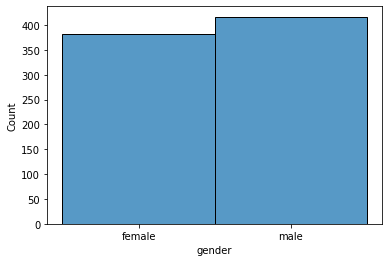

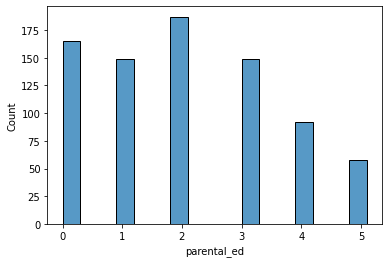

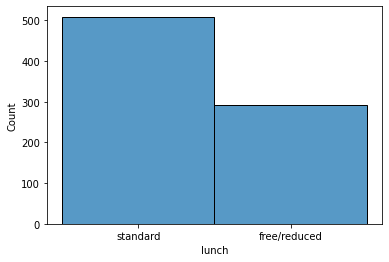

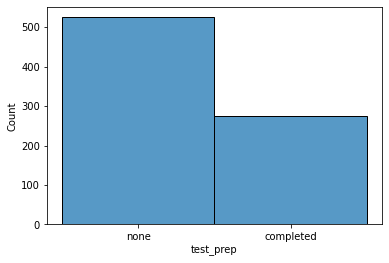

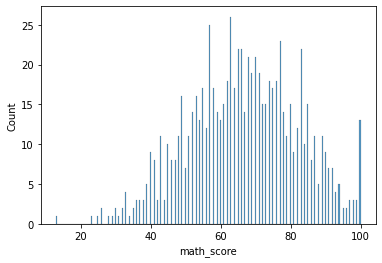

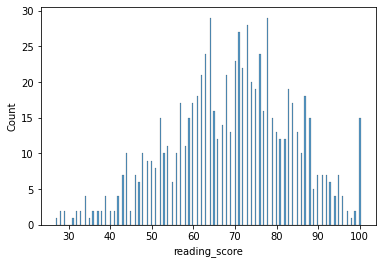

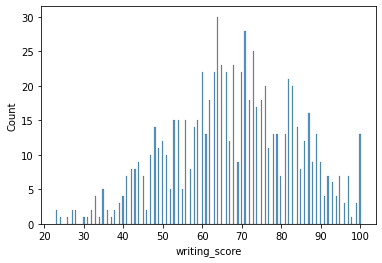

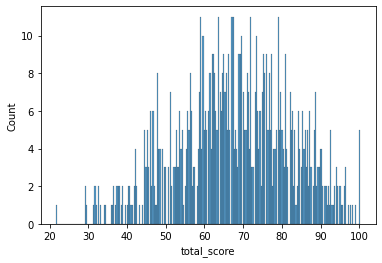

In [13]:
evaluate_df(train)

Test-dataset evaluation


------SAMPLE--------


,gender,lunch,test_prep,math_score,reading_score,writing_score,total_score
192,male,standard,none,77,80,80,79.00
170,female,free/reduced,none,62,71,77,70.00
113,male,standard,none,79,78,77,78.00
182,male,standard,completed,77,77,78,77.33
198,male,standard,none,73,66,59,66.00



------DTYPES--------
gender            object
lunch             object
test_prep         object
math_score         int64
reading_score      int64
writing_score      int64
total_score      float64
dtype: object


------NaN & zero--------
              NA  filled zero  duplicates %na
gender         -     200    -           1   -
lunch          -     200    -           1   -
test_prep      -     200    -           1   -
math_score     -     200    -           1   -
reading_score  -     200    -           1   -
writing_score  -     200    -           1   -
total_score    -     200    -           1   -


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,200,2,male,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lunch,200,2,standard,143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_prep,200,2,none,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
math_score,200.00,NaN,NaN,NaN,65.69,14.13,13.00,55.75,66.00,77.00,100.00
reading_score,200.00,NaN,NaN,NaN,68.47,14.42,36.00,59.00,68.50,79.00,100.00
writing_score,200.00,NaN,NaN,NaN,67.36,15.07,31.00,57.75,66.50,78.00,100.00
total_score,200.00,NaN,NaN,NaN,67.17,13.87,28.67,57.00,66.50,77.33,98.00


['standard' 'free/reduced']
['none' 'completed']
[ 54  72  87  55  56  71  94  93  74  67  60  77  59  51  45  63  85  64
  46  80  69  57  58  75  83  38  61  65  13  28  81  44  86  73  66  70
  53  50  76  68  78  49  48  88  52  40  79  47  36  31  35  91  62  82
  89  84  96 100  90]
[ 43  77  97  55  54  72 100  69  76  62  86  57  51  56  61  81  79  70
  71  66  60  68  74  78  36  88  93  38  91  65  84  63  52  48  89  47
  64  58  87  59  46  53  75  90  83  85  67  73  95  50  45  80  82  98]
[ 45  77 100  55  43  69  93  61  58  90  60  72  62  78  70  54  79  67
  65  73  59  66  47  63  80  37  85  97  31  94  50  89  64  46  76  71
  86  57  56  49  52  75  36  92  84  68  44  32  42  53  81  39  88  48
  51  82  40]
[47.33333333 75.33333333 94.66666667 55.         51.         70.66666667
 98.         95.33333333 68.         73.33333333 60.         84.33333333
 57.         66.66666667 49.         52.         62.         95.
 74.         71.         67.66666667 50.333333

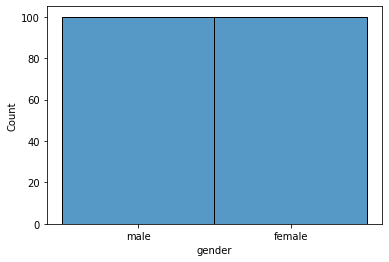

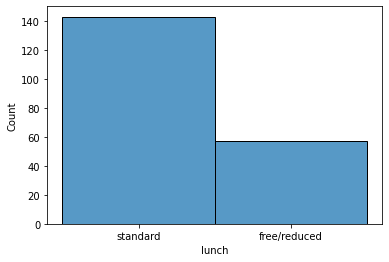

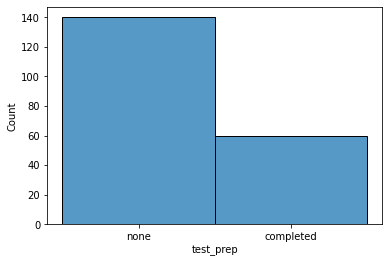

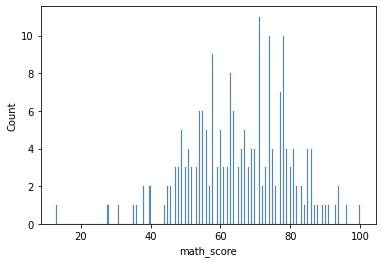

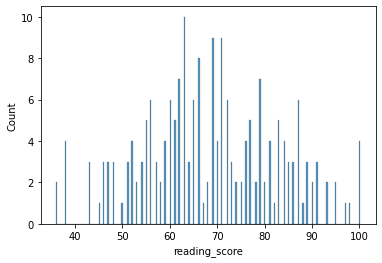

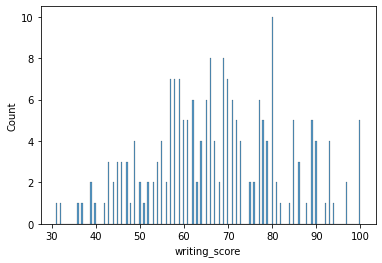

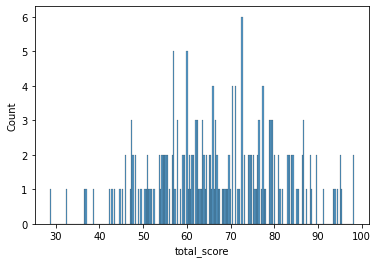

In [14]:
evaluate_df(test)

## Gender Value Counts & Percentage In Dataset

In [15]:
print('Train:')
print(train['gender'].value_counts())
print()
print('Percentage, train:')
print(train.gender.value_counts(normalize=True))
print()
print('Test:')
print(test['gender'].value_counts())
print()
print('Percentage, test:')
print(test.gender.value_counts(normalize=True))

Train:
male      417
female    383
Name: gender, dtype: int64

Percentage, train:
male     0.52
female   0.48
Name: gender, dtype: float64

Test:
male      100
female    100
Name: gender, dtype: int64

Percentage, test:
male     0.50
female   0.50
Name: gender, dtype: float64


Gender balance is 50/50.

## Parental Educational Level
Value Counts & Percentage In Dataset

In [16]:
print(train['parental_ed'].value_counts())
print()
print('Percentage:')
print(train.parental_ed.value_counts(normalize=True))

2    187
0    165
1    149
3    149
4     92
5     58
Name: parental_ed, dtype: int64

Percentage:
2   0.23
0   0.21
1   0.19
3   0.19
4   0.12
5   0.07
Name: parental_ed, dtype: float64


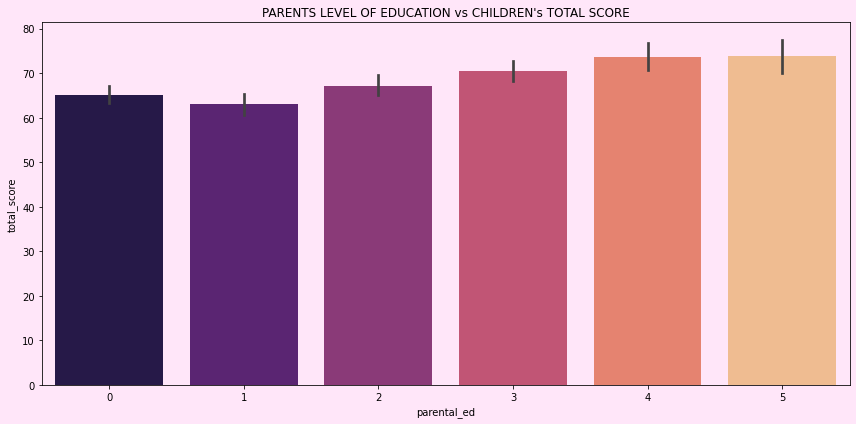

In [17]:
plt.rcParams['figure.facecolor'] = "#ffe6f9"
plt.rcParams['axes.facecolor'] = "#ffe6f9"
plt.figure(figsize=(12,6))
plt.title('PARENTS LEVEL OF EDUCATION vs CHILDREN\'s TOTAL SCORE')
sns.barplot(x=train['parental_ed'],y='total_score',data=train,palette='magma')
plt.tight_layout()

From the above plot its clear that **if the parental educational level is higher - their children tend to score better in all areas** (math, reading, writing).

## Scores

### Test Prep Course vs Scores

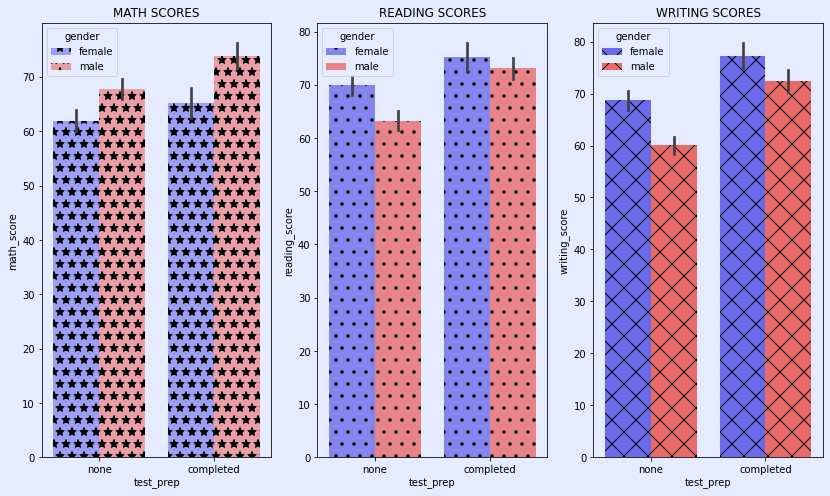

In [18]:
plt.rcParams['figure.facecolor'] = "#e6ecff"
plt.rcParams['axes.facecolor'] = "#e6ecff"
plt.figure(figsize=(14,8))
plt.subplot(1, 3, 1)
sns.barplot(x='test_prep',y='math_score',data=train,hue='gender',palette='seismic',**{'hatch':'*','alpha':0.6,'linewidth':2})
plt.title('MATH SCORES')
plt.subplot(1, 3, 2)
sns.barplot(x='test_prep',y='reading_score',data=train,hue='gender',palette='seismic',**{'hatch':'.','alpha':0.8,'linewidth':2})
plt.title('READING SCORES')
plt.subplot(1, 3, 3)
sns.barplot(x='test_prep',y='writing_score',data=train,hue='gender',palette='seismic',**{'hatch':'x','linewidth':2})
plt.title('WRITING SCORES')
plt.show()

- From the first plot we can see the **math** *scores of boys are higher irrespectively* of the prep course comletion.
- From the next two plots we can see that *girls perform better in **reading and writing***.
- From all three graphs its clear that *if the prep course is comleted students achieve higher scores*.

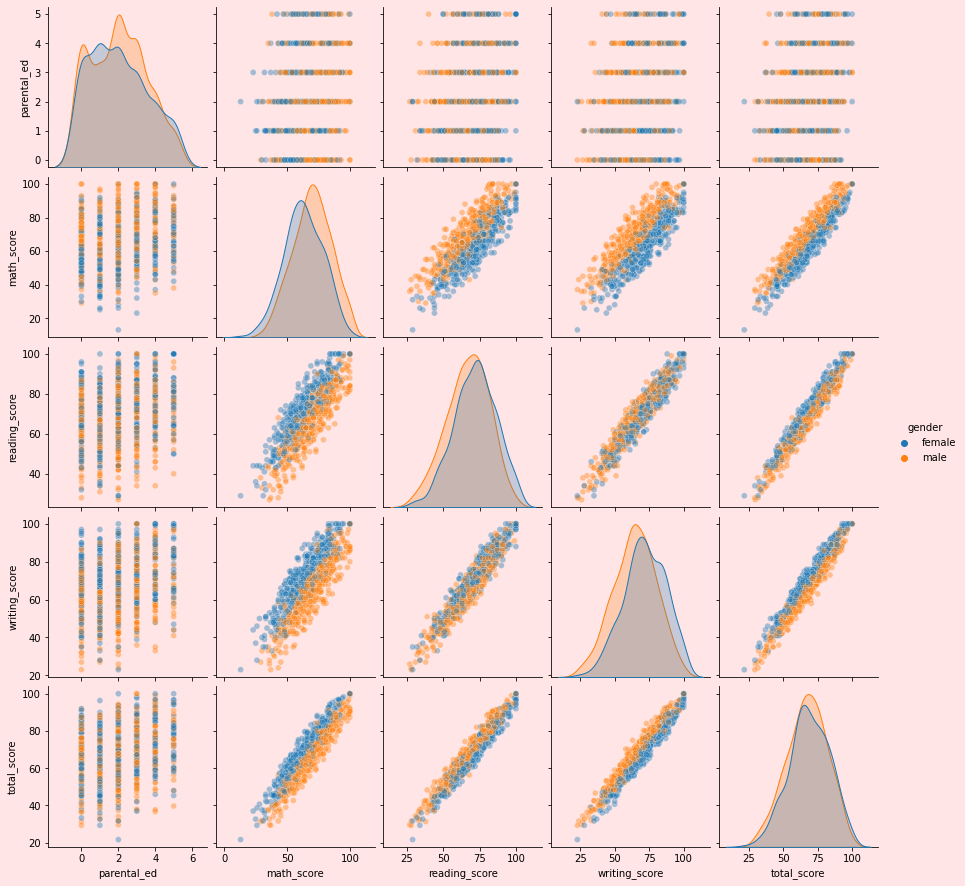

In [19]:
plt.rcParams['axes.facecolor'] = "#ffe5e5"
plt.rcParams['figure.facecolor'] = "#ffe5e5"
sns.pairplot(data=train,hue='gender',plot_kws={'alpha':0.4})

From the above plot it is clear that all the scores increase linearly with each other.

### Heatmap

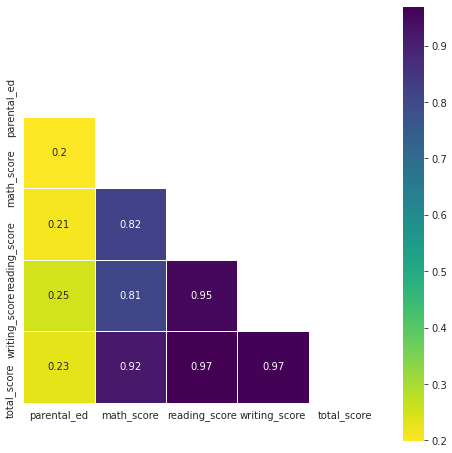

In [20]:
corr = train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(corr,mask=mask,square=True,linewidths=.7,cmap="viridis_r",annot=True)

Points noted from above heatmap:

- High correlations between `total_score` and `individual_scores`
- `writing_score` and `reading_score` are highly correlated = if a student reads well then student also writes well.
- `math_score` has a high correlation with `total_score`, but doesnt have as high correlation with other individual scores = if a student performs well in maths, he won't necessarily perform as good in reading or writing.

### Lunch vs Scores

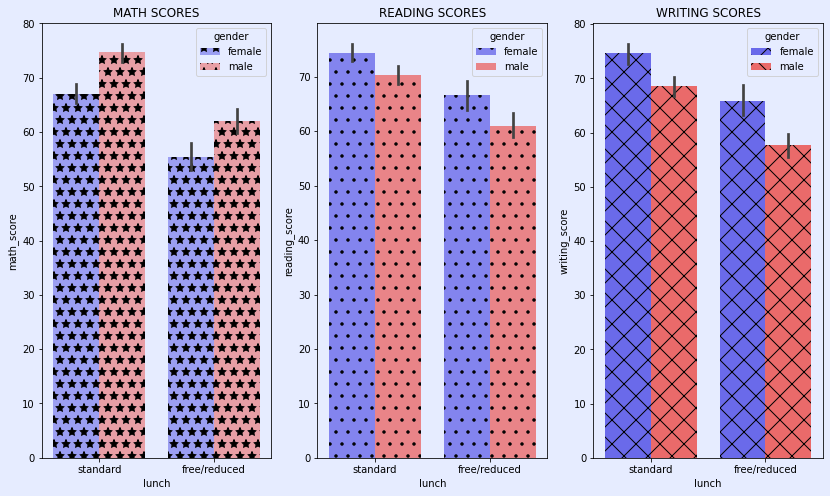

In [21]:
plt.rcParams['figure.facecolor'] = "#e6ecff"
plt.rcParams['axes.facecolor'] = "#e6ecff"
plt.figure(figsize=(14,8))
plt.subplot(1, 3, 1)
sns.barplot(x='lunch',y='math_score',data=train,hue='gender',palette='seismic',**{'hatch':'*','alpha':0.6,'linewidth':2})
plt.title('MATH SCORES')
plt.subplot(1, 3, 2)
sns.barplot(x='lunch',y='reading_score',data=train,hue='gender',palette='seismic',**{'hatch':'.','alpha':0.8,'linewidth':2})
plt.title('READING SCORES')
plt.subplot(1, 3, 3)
sns.barplot(x='lunch',y='writing_score',data=train,hue='gender',palette='seismic',**{'hatch':'x','linewidth':2})
plt.title('WRITING SCORES')
plt.show()

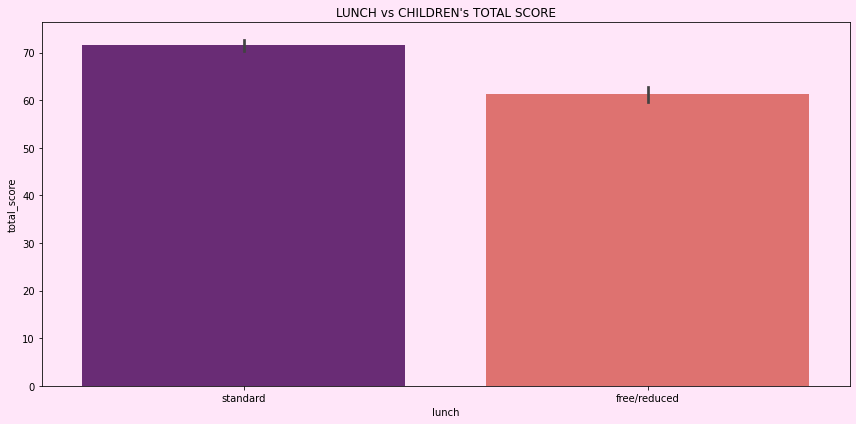

In [22]:
plt.rcParams['figure.facecolor'] = "#ffe6f9"
plt.rcParams['axes.facecolor'] = "#ffe6f9"
plt.figure(figsize=(12,6))
plt.title('LUNCH vs CHILDREN\'s TOTAL SCORE')
sns.barplot(x=train['lunch'],y='total_score',data=train,palette='magma')
plt.tight_layout()

In all the cases the scores are higher by having the standard lunch.

- **Free or Reduced** price lunches are offered to students whos **parents have on low annual household income**.
- *Students with `standard` lunch live in a household with **high income**.*

### Toppers

In [23]:
top_scorers = train[(train['math_score'] > 90) & (train['reading_score'] > 90) & (train['writing_score']>90)]\
.sort_values(by=['total_score'],ascending=False)
print('Number of Toppers:', len(top_scorers))
print()
print(top_scorers.head(10))
print()

Number of Toppers: 20

     gender  parental_ed         lunch  test_prep  math_score  reading_score  \
44   female            2      standard  completed         100            100   
349  female            5      standard  completed         100            100   
466  female            4      standard  completed         100            100   
419    male            3      standard  completed         100            100   
331    male            3      standard  completed         100            100   
54     male            4      standard  completed         100             97   
108  female            3      standard  completed          95            100   
326  female            3      standard  completed          94             99   
521  female            4      standard  completed          91            100   
219  female            5  free/reduced  completed          92            100   

     writing_score  total_score  
44             100       100.00  
349            100       100

### Other Scorers

In [24]:
other_scorers = train[(train['math_score'] <= 90) & (train['reading_score'] <= 90) & (train['writing_score']<=90)]\
.sort_values(by=['total_score'],ascending=False)
print('Number of Other Scorers:', len(other_scorers))
print()
print(other_scorers.head(10))

Number of Other Scorers: 708

     gender  parental_ed     lunch  test_prep  math_score  reading_score  \
736    male            1  standard  completed          89             87   
570    male            3  standard  completed          90             89   
244    male            2  standard  completed          89             87   
402  female            1  standard       none          90             88   
798    male            0  standard  completed          89             87   
431    male            4  standard  completed          90             88   
514  female            0  standard       none          90             88   
682    male            2  standard       none          89             90   
445  female            4  standard       none          87             89   
181    male            1  standard  completed          90             82   

     writing_score  total_score  
736             90        88.67  
570             87        88.67  
244             89        88.33

In [25]:
top_scorers.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,20,2,female,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parental_ed,20.00,NaN,NaN,NaN,3.50,1.15,1.00,3.00,4.00,4.00,5.00
lunch,20,2,standard,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_prep,20,2,completed,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
math_score,20.00,NaN,NaN,NaN,95.40,3.76,91.00,92.00,94.50,100.00,100.00
reading_score,20.00,NaN,NaN,NaN,97.85,2.72,92.00,95.75,99.50,100.00,100.00
writing_score,20.00,NaN,NaN,NaN,97.55,2.86,91.00,95.75,98.50,100.00,100.00
total_score,20.00,NaN,NaN,NaN,96.93,2.38,92.67,95.00,96.67,99.25,100.00


## Toppers vs Others

Let's have a look on parent's educational level of toppers and compare it to other scorers (non-toppers).

In [26]:
print('Parental Ed Level Percentage for Top Scorers:')
print(top_scorers.parental_ed.value_counts(normalize=True))

Parental Ed Level Percentage for Top Scorers:
4   0.35
3   0.25
5   0.20
2   0.15
1   0.05
Name: parental_ed, dtype: float64


In [27]:
print('Parental Ed Level Percentage for Other Scorers:')
print(other_scorers.parental_ed.value_counts(normalize=True))

Parental Ed Level Percentage for Other Scorers:
2   0.24
0   0.22
1   0.20
3   0.18
4   0.10
5   0.06
Name: parental_ed, dtype: float64


Top Scorers' parents have higher educational level compared with Other Scorers:
- Top Scorers: 80% of parents have university degree (Levels: 3,4,5)
- Other Scorers: 34% of parents have university degree (Levels: 3,4,5)

- Top Scorers: 55% of parents have graduated university (Levels: 4,5)
- Other Scorers: 16% of parents have graduated university (Levels: 4,5)

- Top Scorers: 20% of parents have Masters Degree (Level 5)
- Other Scorers: 6% of parents have Masters Degree (Level 5)

### Overall Pass vs Fail

Let's create an Overall Passmark to evaluate overall performance (Pass / Fail). 

In [28]:
overall_passmark = 60*3

In [29]:
train['overall_pass'] = np.where(train['total_score'] < overall_passmark, '0', '1')
train.overall_pass.value_counts()

0    800
Name: overall_pass, dtype: int64

In [30]:
test['overall_pass'] = np.where(test['total_score'] < overall_passmark, '0', '1')
test.overall_pass.value_counts()

0    200
Name: overall_pass, dtype: int64

The Pass/Fail Ratio in Train and Test is the same: approx. 70% of students Pass the tests.

### Income: Low & High

Let's calculate features: Low Income and High Income for datasets 

In [31]:
# Low-income
train.loc[(train['test_prep'] != 'completed') & (train['lunch'] != 'standard'), 'low_income'] = 1
train['low_income'] = train['low_income'].fillna(0).astype('int')

# High-income
train.loc[(train['test_prep'] == 'completed') & (train['lunch'] != 'standard'), 'high_income'] = 1
train['high_income']= train['high_income'].fillna(0).astype('int')

# Low-income
test.loc[(test['test_prep'] != 'completed') & (test['lunch'] != 'standard'), 'low_income'] = 1
test['low_income'] = test['low_income'].fillna(0).astype('int')

# High-income
test.loc[(test['test_prep'] == 'completed') & (test['lunch'] != 'standard'), 'high_income'] = 1
test['high_income']=test['high_income'].fillna(0).astype('int')


In [32]:
train.head(10)

,gender,parental_ed,lunch,test_prep,math_score,reading_score,writing_score,total_score,overall_pass,low_income,high_income
0,female,1,standard,none,62,76,67,68.33,0,0,0
1,male,4,standard,none,79,57,58,64.67,0,0,0
2,female,2,standard,none,77,86,84,82.33,0,0,0
3,female,0,free/reduced,none,45,46,49,46.67,0,1,0
4,male,3,standard,completed,82,83,85,83.33,0,0,0
5,female,3,free/reduced,none,32,41,39,37.33,0,1,0
6,female,1,free/reduced,completed,53,70,65,62.67,0,0,1
7,male,2,free/reduced,none,57,47,42,48.67,0,1,0
8,male,0,free/reduced,none,67,65,54,62.00,0,1,0
9,male,1,standard,none,74,71,70,71.67,0,0,0


### Income: Other

In [33]:
# function for creation of column: Other family income 
train['other_income'] = np.nan 

def other_income_cat(row):
    if row['low_income']==1:
        return '0'
    elif row['high_income']==1:
        return '0'
    else:
        return '1'

train['other_income'] = train.apply(other_income_cat, axis=1)
train['other_income'] = train['other_income'].astype('int')
train['other_income'].value_counts(dropna=False)

1    509
0    291
Name: other_income, dtype: int64

In [34]:
# function for creation of column: Other family income 
test['other_income'] = np.nan 

def other_income_cat(row):
    if row['low_income']==1:
        return '0'
    elif row['high_income']==1:
        return '0'
    else:
        return '1'

test['other_income'] = test.apply(other_income_cat, axis=1)
test['other_income'] = test['other_income'].astype('int')
test['other_income'].value_counts(dropna=False)

1    143
0     57
Name: other_income, dtype: int64

In [35]:
train.head(10)

,gender,parental_ed,lunch,test_prep,math_score,reading_score,writing_score,total_score,overall_pass,low_income,high_income,other_income
0,female,1,standard,none,62,76,67,68.33,0,0,0,1
1,male,4,standard,none,79,57,58,64.67,0,0,0,1
2,female,2,standard,none,77,86,84,82.33,0,0,0,1
3,female,0,free/reduced,none,45,46,49,46.67,0,1,0,0
4,male,3,standard,completed,82,83,85,83.33,0,0,0,1
5,female,3,free/reduced,none,32,41,39,37.33,0,1,0,0
6,female,1,free/reduced,completed,53,70,65,62.67,0,0,1,0
7,male,2,free/reduced,none,57,47,42,48.67,0,1,0,0
8,male,0,free/reduced,none,67,65,54,62.00,0,1,0,0
9,male,1,standard,none,74,71,70,71.67,0,0,0,1


In [36]:
# Replacing NaN values & Changing Type to int
train['low_income'] = train['low_income'].fillna(0).astype('int')
train['high_income'] = train['high_income'].fillna(0).astype('int')
test['low_income'] = test['low_income'].fillna(0).astype('int')
test['high_income'] = test['high_income'].fillna(0).astype('int')

In [37]:
train.head(10)

,gender,parental_ed,lunch,test_prep,math_score,reading_score,writing_score,total_score,overall_pass,low_income,high_income,other_income
0,female,1,standard,none,62,76,67,68.33,0,0,0,1
1,male,4,standard,none,79,57,58,64.67,0,0,0,1
2,female,2,standard,none,77,86,84,82.33,0,0,0,1
3,female,0,free/reduced,none,45,46,49,46.67,0,1,0,0
4,male,3,standard,completed,82,83,85,83.33,0,0,0,1
5,female,3,free/reduced,none,32,41,39,37.33,0,1,0,0
6,female,1,free/reduced,completed,53,70,65,62.67,0,0,1,0
7,male,2,free/reduced,none,57,47,42,48.67,0,1,0,0
8,male,0,free/reduced,none,67,65,54,62.00,0,1,0,0
9,male,1,standard,none,74,71,70,71.67,0,0,0,1


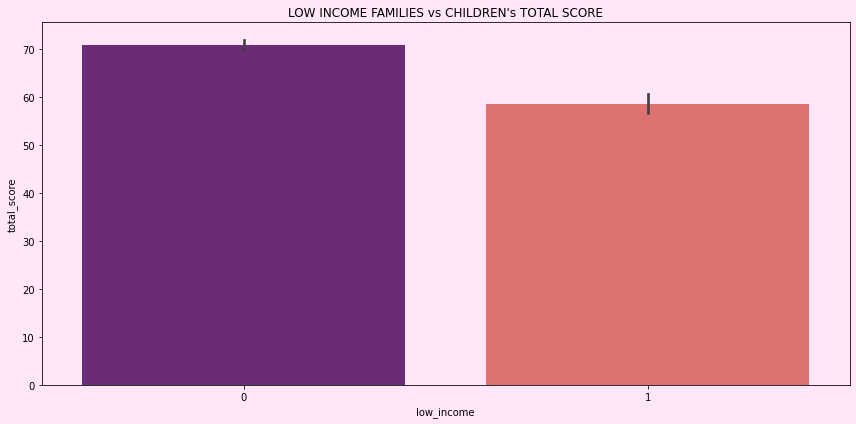

In [38]:
plt.rcParams['figure.facecolor'] = "#ffe6f9"
plt.rcParams['axes.facecolor'] = "#ffe6f9"
plt.figure(figsize=(12,6))
plt.title('LOW INCOME FAMILIES vs CHILDREN\'s TOTAL SCORE')
sns.barplot(x=train['low_income'],y='total_score',data=train,palette='magma')
plt.tight_layout()

The **total score of children from Low-income families is lower**.

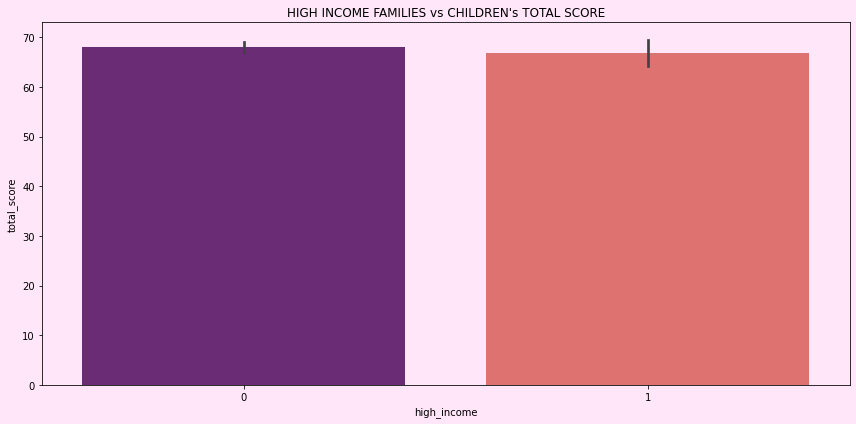

In [39]:
plt.rcParams['figure.facecolor'] = "#ffe6f9"
plt.rcParams['axes.facecolor'] = "#ffe6f9"
plt.figure(figsize=(12,6))
plt.title('HIGH INCOME FAMILIES vs CHILDREN\'s TOTAL SCORE')
sns.barplot(x=train['high_income'],y='total_score',data=train,palette='magma')
plt.tight_layout()

The total score of children from High-income families is approximately the same as from non-high-income families.

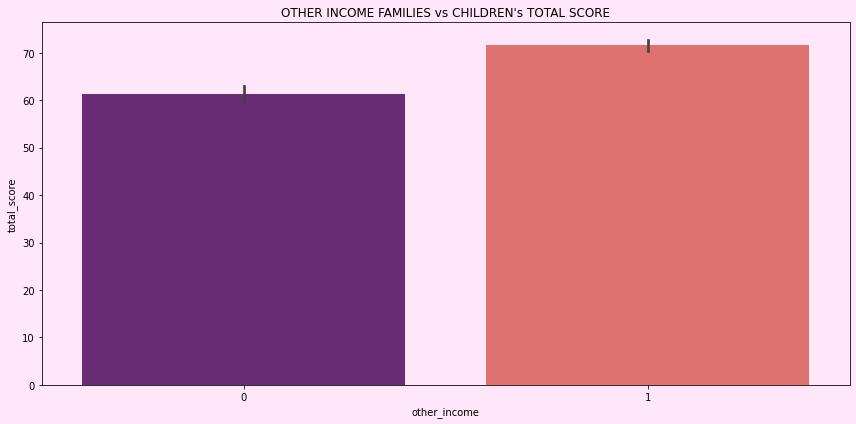

In [40]:
plt.rcParams['figure.facecolor'] = "#ffe6f9"
plt.rcParams['axes.facecolor'] = "#ffe6f9"
plt.figure(figsize=(12,6))
plt.title('OTHER INCOME FAMILIES vs CHILDREN\'s TOTAL SCORE')
sns.barplot(x=train['other_income'],y='total_score',data=train,palette='magma')
plt.tight_layout()

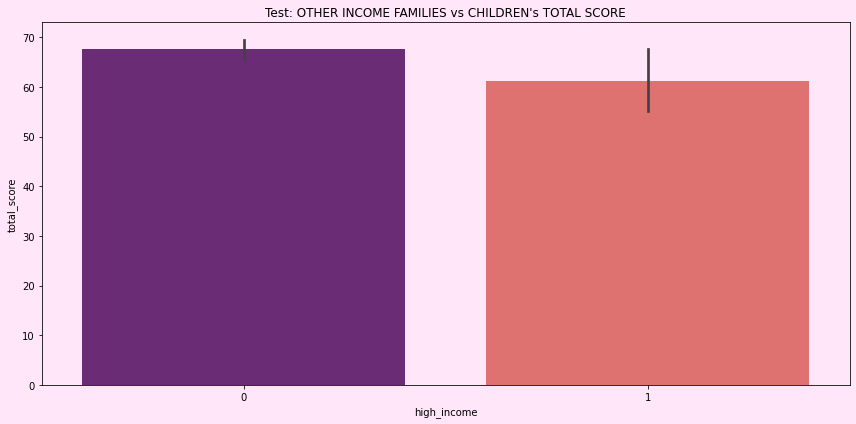

In [41]:
plt.rcParams['figure.facecolor'] = "#ffe6f9"
plt.rcParams['axes.facecolor'] = "#ffe6f9"
plt.figure(figsize=(12,6))
plt.title('Test: OTHER INCOME FAMILIES vs CHILDREN\'s TOTAL SCORE')
sns.barplot(x=test['high_income'],y='total_score',data=test,palette='magma')
plt.tight_layout()

The total score of children from other-income-families is higher, compared to children from families with Low and High income.

### Fail/Pass vs Ed. Level

In [42]:
failers = train.loc[train['overall_pass'] != '1']
print('Number of Failers',len(failers))

Number of Failers 800


In [43]:
passers = train.loc[train['overall_pass'] == '1']
print('Number of Passers',len(passers))

Number of Passers 0


In [44]:
print('Failers: Parental Ed Level Percentage')
print(failers.parental_ed.value_counts(normalize=True))

Failers: Parental Ed Level Percentage
2   0.23
0   0.21
1   0.19
3   0.19
4   0.12
5   0.07
Name: parental_ed, dtype: float64


Only 25% of failers' parents have attended University.

In [45]:
print('Passers: Parental Ed Level Percentage')
print(passers.parental_ed.value_counts(normalize=True))

Passers: Parental Ed Level Percentage
Series([], Name: parental_ed, dtype: float64)


41% of passers' parents have attended University.

# Data Preprocessing

In [46]:
train.columns

Index(['gender', 'parental_ed', 'lunch', 'test_prep', 'math_score',
       'reading_score', 'writing_score', 'total_score', 'overall_pass',
       'low_income', 'high_income', 'other_income'],
      dtype='object')

In [47]:
test.columns

Index(['gender', 'lunch', 'test_prep', 'math_score', 'reading_score',
       'writing_score', 'total_score', 'overall_pass', 'low_income',
       'high_income', 'other_income'],
      dtype='object')

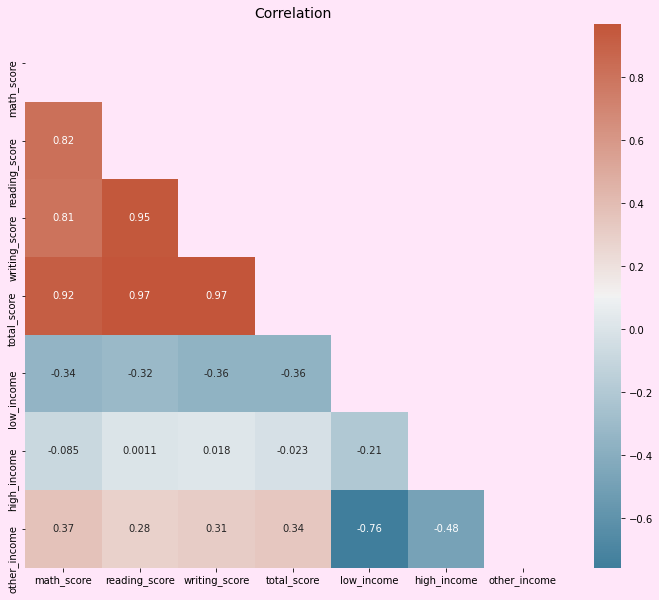

In [48]:
# Correlation

df_corr = train.drop('parental_ed', axis=1)
corr = df_corr.corr()

# Set up the matplotlib plot configuration

f, ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle

mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap

cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap

sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

plt.title("Correlation", fontsize='14')
plt.show()

In [49]:
# Preprocessing data
train["lunch"] = le.fit_transform(train["lunch"])
train["test_prep"] = le.fit_transform(train["test_prep"])
train["gender"] = le.fit_transform(train["gender"])

In [50]:
train["math_score"] /= 100
train["reading_score"] /= 100
train["writing_score"] /= 100
train["total_score"] /= 100

In [51]:
test["lunch"] = le.fit_transform(test["lunch"])
test["test_prep"] = le.fit_transform(test["test_prep"])
test["gender"] = le.fit_transform(test["gender"])

In [52]:
test["math_score"] /= 100
test["reading_score"] /= 100
test["writing_score"] /= 100
test["total_score"] /= 100

In [53]:
# copying train datasets

train_pre = train.copy()

In [54]:
train_pre.head()

,gender,parental_ed,lunch,test_prep,math_score,reading_score,writing_score,total_score,overall_pass,low_income,high_income,other_income
0,0,1,1,1,0.62,0.76,0.67,0.68,0,0,0,1
1,1,4,1,1,0.79,0.57,0.58,0.65,0,0,0,1
2,0,2,1,1,0.77,0.86,0.84,0.82,0,0,0,1
3,0,0,0,1,0.45,0.46,0.49,0.47,0,1,0,0
4,1,3,1,0,0.82,0.83,0.85,0.83,0,0,0,1


In [55]:
test = test.drop(["high_income"], axis=1).copy()
test.head()

,gender,lunch,test_prep,math_score,reading_score,writing_score,total_score,overall_pass,low_income,other_income
0,1,1,1,0.54,0.43,0.45,0.47,0,0,1
1,0,1,1,0.72,0.77,0.77,0.75,0,0,1
2,0,1,1,0.87,0.97,1.00,0.95,0,0,1
3,1,1,1,0.55,0.55,0.55,0.55,0,0,1
4,1,1,1,0.56,0.54,0.43,0.51,0,0,1


In [56]:
X = train_pre.drop(["parental_ed","high_income"], axis=1)
y = train_pre["parental_ed"]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RNDM, stratify=y)
class_names = ["0", "1", "2", "3", "4", "5"]

Building lot's of basic models in order to understand which model works better without any parameter tuning.

In [58]:
clf = LazyClassifier(random_state=RNDM, verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|███████████████████████████████████████████| 29/29 [00:02<00:00, 13.45it/s]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
GaussianNB                         0.29               0.28    None      0.28   
BernoulliNB                        0.25               0.23    None      0.23   
NearestCentroid                    0.21               0.22    None      0.20   
Perceptron                         0.24               0.21    None      0.21   
CalibratedClassifierCV             0.26               0.21    None      0.22   
LinearDiscriminantAnalysis         0.24               0.20    None      0.23   
LogisticRegression                 0.24               0.20    None      0.22   
SVC                                0.24               0.19    None      0.21   
LinearSVC                          0.23               0.19    None      0.21   
ExtraTreesClassifier               0.20               0.19    None      0.20   
RidgeClassifier                    0.23 

The best model is **GaussianNB**.

# Model: GaussianNB

In [59]:
model = GaussianNB()

In [60]:
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
f1_weighted = metrics.f1_score(y_test, y_pred, average='weighted')
f1_None = metrics.f1_score(y_test, y_pred, average=None)

print("Accuracy:", acc.round(4))
print("F1-Score micro:",  f1_micro.round(4))
print("F1-Score macro:",  f1_macro.round(4))
print("F1-Score weighted:",  f1_weighted.round(4))
print("F1-Score average none:",  f1_None.round(2))

Accuracy: 0.2917
F1-Score micro: 0.2917
F1-Score macro: 0.2608
F1-Score weighted: 0.2765
F1-Score average none: [0.39 0.32 0.17 0.31 0.26 0.11]


# Prediction

In [61]:
# JSON Export
prediction = model.predict(test)
df_prediction = pd.DataFrame(prediction, columns=['target'])
json_prediction = df_prediction.to_json()
with open('predictions.json', 'w') as outfile:
    outfile.write(json_prediction)

# Final Conclusion

The student's academic results **are influenced by the educational level of the parents**.

- Children from families with higher educational levels tend to score better in all areas (`math, reading, writing`).
- The `math scores` of boys are higher irrespectively of the prep course completion.
- Girls perform better in reading and writing.
- If the test preparation course is completed - students achieve higher scores.
- All the scores increase linearly with each other.

Correlations
- High correlations between `total_score` and `individual_scores`
- `writing_score` and `reading_score` are highly correlated = if a student reads well then the student also writes well.
- `math_score` has a high correlation with `total_score`, but doesn't have an as high correlation with other individual scores = if a student performs well in maths, he won't necessarily perform as well in reading or writing.

Lunch
- `Free or Reduced` price lunches are offered to students whose parents have low annual household income.
- Students with `standard` lunch live in a household with a high income.
- In all the cases the **scores are higher by having the `standard` lunch**.

Top Scorers' parents have higher educational levels compared with Other Scorers:
- Top Scorers: 80% of parents have a university degree (Levels: 3,4,5)
- Other Scorers: 34% of parents have a university degree (Levels: 3,4,5)
- Top Scorers: 55% of parents have graduated university (Levels: 4,5)
- Other Scorers: 16% of parents have graduated university (Levels: 4,5)
- Top Scorers: 20% of parents have a Master's Degree (Level 5)
- Other Scorers: 6% of parents have a Master's Degree (Level 5)

Exam Pass/Fail
- The Exam Pass/Fail Ratio in Train and Test is the same: approx. *70% of students Pass the exam*.
- The `total score` of children from **Low-income families is lower**.
- The `total score` of children from **High-income families** is approximately the same as that from non-high-income families.
- The `total score` of children from **other-income families is higher**, compared to children from families with Low and High income.
- **25%** of parents to students who **Failed exam** have attended University.
- **41%** of parents to students who **Passed exam** have attended University.